# Using Amazon SageMaker to Clone Driving Behavior
# Introduction
This Notebook is a prototype for a Level 300-400 re:Invent 2018 Bootcamp where participants will perform the following:

1. Drive a vehicle on a mock track using a [Self-Driving Car Simulator](https://github.com/udacity/self-driving-car-sim) to capture the vehicle's telemetry.
2. Create a Machine Learning (ML) Pipeline, using the telemetry data, to clone the driving behavior as part of a Deep Learning model.
3. Deploy the behavioral cloning model to a production SageMaker Inference Endpoint.
4. Use the Endpoint to autonomously drive the vehicle around a second mock track.

In [1]:
# Suggested Libraries for conda_mxnet
import warnings
import zipfile
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import mxnet as mx
import seaborn as sns
from mxnet import nd, autograd, gluon
from IPython.display import display
from sklearn.model_selection import train_test_split
warnings.simplefilter('ignore')
%matplotlib inline

# Suggested Libraries for SageMaker
import boto3
import sagemaker
from sagemaker.mxnet import MXNet

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

---
# Data Exploration
## Sample Dataset
[sample dataset](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip)

In [2]:
# Download and extract Sample Data
file = mx.test_utils.download(url='https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip')
with zipfile.ZipFile(file) as zf:
    zf.extractall()

In [3]:
data_df = pd.read_csv('./data/driving_log.csv')
data_df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


## Data Exploration

In [4]:
# Data Overview
print("Dataset Shape: {}".format(data_df.shape))
print(data_df.describe())

Dataset Shape: (8036, 7)
          steering     throttle        brake        speed
count  8036.000000  8036.000000  8036.000000  8036.000000
mean      0.004070     0.869660     0.001970    28.169839
std       0.128840     0.301326     0.036565     6.149327
min      -0.942695     0.000000     0.000000     0.502490
25%       0.000000     0.985533     0.000000    30.183093
50%       0.000000     0.985533     0.000000    30.186400
75%       0.000000     0.985533     0.000000    30.186640
max       1.000000     0.985533     1.000000    30.709360


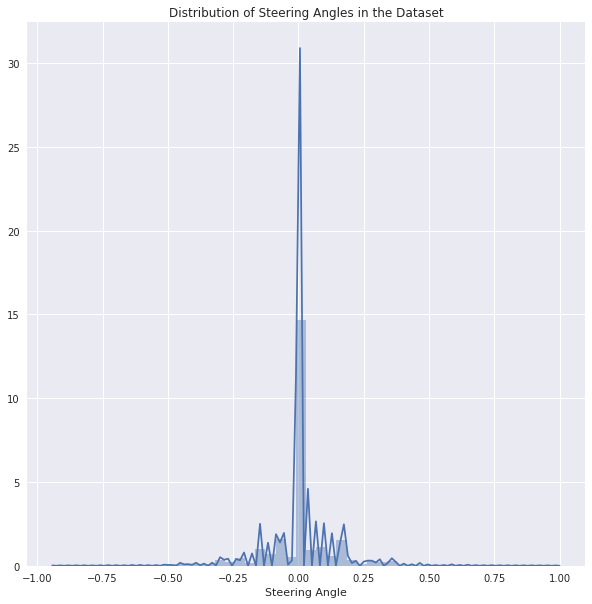

In [5]:
# Visualize the distribution of the data
sns.set(rc={'figure.figsize':(10, 10)})
fig = sns.distplot(data_df.steering)
plt.xlabel("Steering Angle")
plt.title("Distribution of Steering Angles in the Dataset")
plt.show(fig);

The Sample Dataset is skewed toward the zero steering angle and therefore more training data will need to be added during the Data Preprocessing step.

---
# Data Preprocesing
## Feature Extraction

In [6]:
# Separate the features
X = data_df[['center', 'left', 'right']].values
y = data_df['steering'].values

## Image Transformations
1. Crop images for Region of Interest (ROI).
2. Resize images to $66 \times 200 \times 3$ per the NVidia model.
3. Convert to YUV Channels per the NVidia model.

In [7]:
# Image Transofmrations
def crop(image):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    return image[60:-25, :, :] # remove the sky and the car front

def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)

def rgb2yuv(image):
    """
    Convert the image from RGB to YUV
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

## Image Augmentation
- Randomly choose right, left or center images.
- For left image, steering angle is adjusted by +0.2
- For right image, steering angle is adjusted by -0.2
- Randomly flip image left <--> right
- Randomly translate image horizontally with steering angle adjustment (0.002 per pixel shift)
- Randomly translate image virtically
- Randomly added shadows
- Randomly altering image brightness (lighter or darker)
- Randonly apply distortions

In [8]:
# Randomly Flip image Left/Right
def flip(image, steering_angle):
    """
    Randomly flit the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

In [9]:
# Randomly Translate Vertically and Horizontally
def translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

In [10]:
def distort(image):
    ''' 
    method for adding random distortion to dataset images, including random brightness adjust, and a random
    vertical shift of the horizon position
    '''
    new_img = image.astype(float)
    # random brightness - the mask bit keeps values from going beyond (0,255)
    value = np.random.randint(-28, 28)
    if value > 0:
        mask = (new_img[:,:,0] + value) > 255 
    if value <= 0:
        mask = (new_img[:,:,0] + value) < 0
    new_img[:,:,0] += np.where(mask, 0, value)
    # random shadow - full height, random left/right side, random darkening
    h,w = new_img.shape[0:2]
    mid = np.random.randint(0,w)
    factor = np.random.uniform(0.6,0.8)
    if np.random.rand() > .5:
        new_img[:,0:mid,0] *= factor
    else:
        new_img[:,mid:w,0] *= factor
    # randomly shift horizon
    h,w,_ = new_img.shape
    horizon = 2*h/5
    v_shift = np.random.randint(-h/8,h/8)
    pts1 = np.float32([[0,horizon],[w,horizon],[0,h],[w,h]])
    pts2 = np.float32([[0,horizon+v_shift],[w,horizon+v_shift],[0,h],[w,h]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    new_img = cv2.warpPerspective(new_img,M,(w,h), borderMode=cv2.BORDER_REPLICATE)
    return new_img.astype(np.uint8)

In [11]:
# Radomly Adjust Brightness
def brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

In [12]:
def load(data_dir, image_file):
    """
    Load RGB images from a file
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))

def choose(data_dir, center, left, right, steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load(data_dir, left), steering_angle + 0.2
    elif choice == 1:
        return load(data_dir, right), steering_angle - 0.2
    return load(data_dir, center), steering_angle

def transform(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image

### Augmented Image Examples

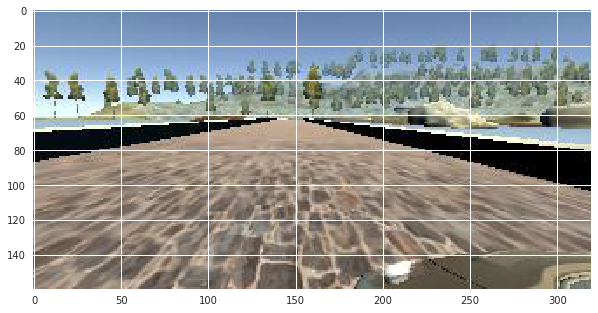

In [24]:
# Origional 'left' image
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
random_image = X[100][1]
img = load('data', random_image)
plt.imshow(img);

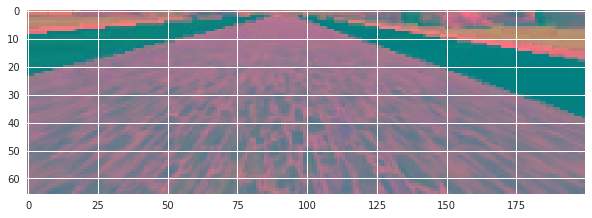

In [25]:
# Preprocessed "original" image
plt.imshow(transform(img));

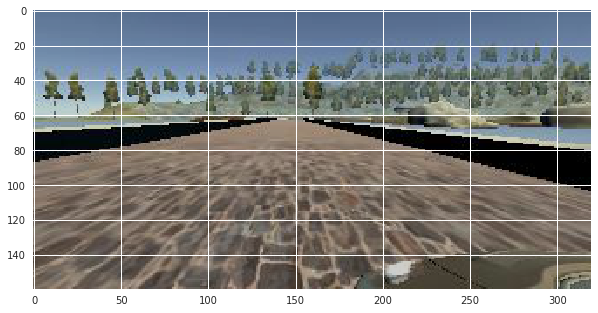

In [26]:
# Add Random brightness
plt.imshow(brightness(img));

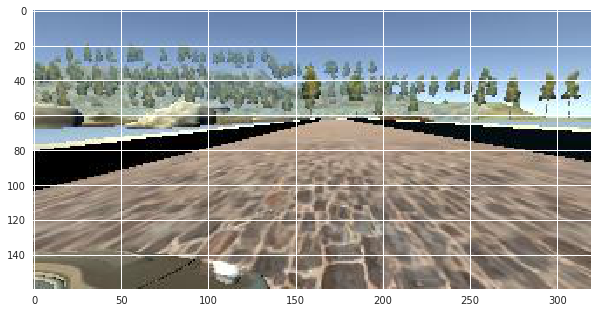

In [27]:
# Flip
img = load('data', random_image)
plt.imshow(flip(img, 0)[0]);

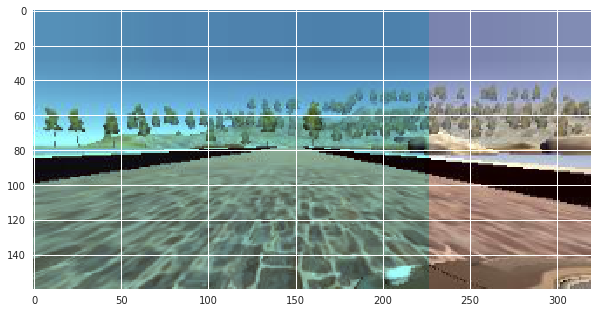

In [28]:
# Distort
plt.imshow(distort(img));

## Image Augmentation Pipeline...
Create the Training and Vlaidation Datasets using a 90/10 split respectivley. There is no Test Dataset as the final test will be acomplished using the Simulator.

In [29]:
# Batch Image Generator
HEIGHT, WIDTH, CHANNELS = 66, 200, 3
INPUT_SHAPE = (HEIGHT, WIDTH, CHANNELS)

def augument(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose(data_dir, center, left, right, steering_angle)
    image, steering_angle = flip(image, steering_angle)
    image, steering_angle = translate(image, steering_angle, range_x, range_y)
    image = brightness(image)
    image = distort(image)
    return image, steering_angle


def aug_pipeline(data_dir, image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, HEIGHT, WIDTH, CHANNELS])
    steering = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            # argumentation
            if is_training and np.random.rand() < 0.9:
                image, steering_angle = augument(data_dir, center, left, right, steering_angle)
            else:
                image = load(data_dir, center) 
            # add the image and steering angle to the batch
            images[i] = transform(image)
            steering[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        return np.array(images).astype(np.float32), np.array(steering).astype(np.float32)

In [31]:
X_sample, y_sample = aug_pipeline('data', X, y, len(X), True)

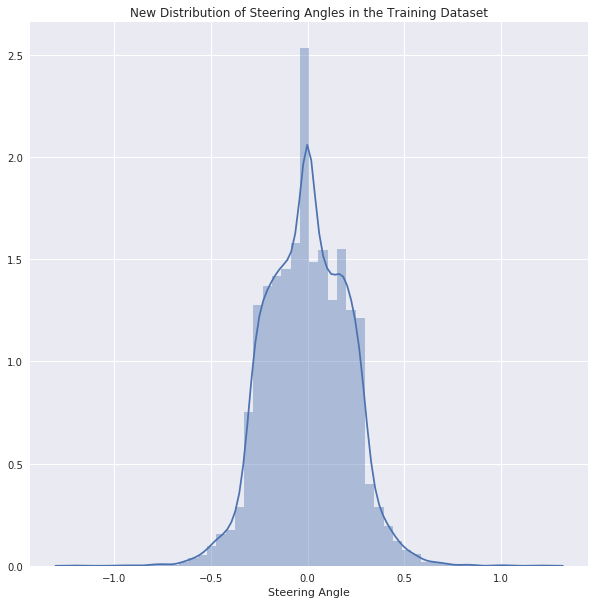

In [32]:
# Plot New Distribution of training examples
fig = sns.distplot(y_sample)
plt.xlabel("Steering Angle")
plt.title("New Distribution of Steering Angles in the Training Dataset")
plt.show(fig);

As can be seen from the sample datatset, the disribution of steering angles is more uniform. Next we create the datasets for the model and upload them to S3.

---
# Pre-trained Model


---
# NVidia Model
[End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/deep-learning-self-driving-cars/)
![Architecture](https://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/08/cnn-architecture-624x890.png)

## Training/Validation Datsets
Using a 90/10 split, the dataset is separated to 90% for Training and 10% for Validation. The final test onm the datset will be handled by the simulator.

In [45]:
# Create Training and Validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

# Preprocess through the pipline
X_train, y_train = aug_pipeline('data', X_train, y_train, len(X_train), True)
X_valid, y_valid = aug_pipeline('data', X_valid, y_valid, len(X_valid), False)

# Reshape images as a 4D Tensor for Gluon CNN
X_train = X_train.reshape(-1, 3, 66, 200)
y_train = y_train.reshape(-1, 1)
X_valid = X_valid.reshape(-1, 3, 66, 200)
y_valid = y_valid.reshape(-1, 1)

# Create local repository for Numpy Arrays
if not os.path.exists('/tmp/data'):
    os.mkdir('/tmp/data')

# Save the Dataset as Numpy Arrays
np.save('/tmp/data/train_X.npy', X_train)
np.save('/tmp/data/train_Y.npy', y_train)
np.save('/tmp/data/valid_X.npy', X_valid)
np.save('/tmp/data/valid_Y.npy', y_valid)

# Upload the Training and Testing Data to S3
input_data = sagemaker_session.upload_data(path='/tmp/data', key_prefix='training_input')
bucket = input_data.split('/')[2]

In [46]:
# Create the Nvidia Model
ctx = mx.cpu()
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Lambda(lambda x: x/127.5-1.0)) #Normalization
    net.add(gluon.nn.Conv2D(
        channels=24,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding=1
    ))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Conv2D(
        channels=36,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding=1
    ))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Conv2D(
        channels=48,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding=1
    ))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Conv2D(
        channels=64,
        kernel_size=3
    ))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Conv2D(
        channels=64,
        kernel_size=3
    ))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Dropout(.5))
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(1164))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Dense(100))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Dense(50))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Dense(10))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Dense(1))
net.hybridize()

In [47]:
# Model plot
#net.collect_params().initialize()
#x = mx.sym.var('data')
#sym = net(x)
#mx.viz.plot_network(sym)

In [48]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [49]:
# Train the model
epochs = 11
square_loss = gluon.loss.L2Loss()
#net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True, ctx=ctx)
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 1.0e-4})
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(
        X_train,
        y_train
    ),
    shuffle=True,
    batch_size=256
)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(
        X_valid,
        y_valid
    ),
    shuffle=False,
    batch_size=256
)

# Placeholder to plot the loss
total_loss = []

for epoch in range(epochs):
#    loss_avg = 0
    curr_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(data.shape[0])
#        curr_loss += nd.sum(loss).asscalar()
#        loss_avg = loss_avg * i / (i + 1) + nd.mean(loss).asscalar() / (i + 1)
        curr_loss += nd.mean(loss).asscalar()
    val_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    total_loss.append(curr_loss/len(train_data))
    print("Epoch {}. Loss: {}; Training Accuracy = {}; Validation Accuracy = {}".format(
        epoch, curr_loss/len(train_data), train_accuracy, val_accuracy
        )
    )

Epoch 0. Loss: 0.021257607972827452; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 1. Loss: 0.019756351758179993; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 2. Loss: 0.01793167537784782; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 3. Loss: 0.015863586217164993; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 4. Loss: 0.015074775072521177; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 5. Loss: 0.014086488377431343; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 6. Loss: 0.013829550095673266; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 7. Loss: 0.013064054964945233; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 8. Loss: 0.01269173358791861; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 9. Loss: 0.012261647586550179; Training Accuracy = 0.9997234513274337

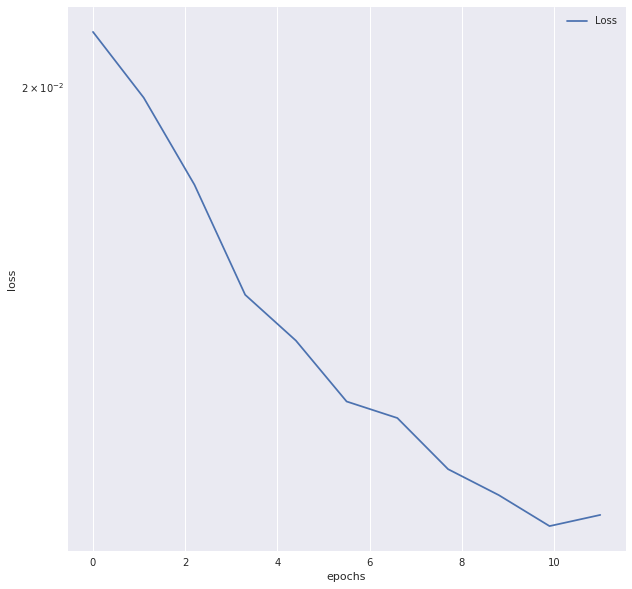

In [50]:
# Plot loss
x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
plt.semilogy(x_axis, total_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Loss'])
plt.show()

---
## Train and Deploy to SageMaker

In [36]:
# Configure SageMaker
import boto3
import sagemaker
from sagemaker.mxnet import MXNet

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

<details>
<summary><strong>`model.py` (click to expand)</strong></summary><p>

```
# Import necessary libraries
import boto3
import os
import io
import logging
import datetime
import json
#import cv2
import mxnet as mx
import numpy as np
from json import dumps, loads
from mxnet import nd, autograd, gluon

# Set logging
logging.getLogger("requests.packages.urllib3.connectionpool").setLevel(logging.WARNING)

# ---------------------------------------------------------------------------- #
#                            Training functions                                #
# ---------------------------------------------------------------------------- #
def train(channel_input_dirs, hyperparameters, hosts, num_gpus, output_data_dir, **kwargs):
    ctx = mx.gpu() if num_gpus > 0 else mx.cpu()
    
    # Set Local vs. Distributed training
    if len(hosts) == 1:
        kvstore = 'device' if num_gpus > 0 else 'local'
    else:
        kvstore = 'dist_device_sync' if num_gpus > 0 else 'dist_sync'
    
    # Load hyperparameters
    epochs = hyperparameters.get('epochs', 11)
    optmizer = hyperparameters.get('optmizer', 'adam')
    lr = hyperparameters.get('learning_rate', 1.0e-4)
    batch_size = hyperparameters.get('batch_size', 64)
    
    # Load Training/Testing Data
    f_path = channel_input_dirs['training']
    train_X, train_Y, test_X, test_Y = load_data(f_path)
    
    # Create Training and Test Data Iterators
    train_data = mx.gluon.data.DataLoader(
        mx.gluon.data.ArrayDataset(
            train_X,
            train_Y
        ),
        shuffle=True,
        batch_size=batch_size
    )
    test_data = mx.gluon.data.DataLoader(
        mx.gluon.data.ArrayDataset(
            test_X,
            test_Y
        ),
        shuffle=False,
        batch_size=batch_size
    )
    
    # Initialize the neural network structure
    net = build_model()
    
    # Parameter Initialization
#    net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True, ctx=ctx)
    net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
    
    # Optimizer
    trainer = gluon.Trainer(net.collect_params(), optmizer, {'learning_rate': lr})
    
    # Cross Entropy Loss Function
    square_loss = gluon.loss.L2Loss()
    
    # Train the model
    for epoch in range(epochs):
        curr_loss = 0
        for i, (data, label) in enumerate(train_data):
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(data.shape[0])
            curr_loss += nd.mean(loss).asscalar()
        val_accuracy = accuracy(test_data, net, ctx)
        train_accuracy = accuracy(train_data, net, ctx)
        print("Epoch {}: Loss: {}; Training Accuracy = {}; Validation Accuracy = {}"\
              .format(epoch, curr_loss/len(train_data), train_accuracy, val_accuracy)
             )

    # Return the model for saving
    return net

def build_model():
    """
    Create the NVidia Model.
    """
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Lambda(lambda x: x/127.5-1.0)) #Normalization
        net.add(gluon.nn.Conv2D(channels=24, kernel_size=(5, 5), strides=(2, 2), padding=1, activation='relu'))
        net.add(gluon.nn.Conv2D(channels=36, kernel_size=(5, 5), strides=(2, 2), padding=1, activation='relu'))
        net.add(gluon.nn.Conv2D(channels=48, kernel_size=(5, 5), strides=(2, 2), padding=1, activation='relu'))
        net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, activation='relu'))
        net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, activation='relu'))
        net.add(gluon.nn.Dropout(.5))
        net.add(gluon.nn.Flatten())
        net.add(gluon.nn.Dense(1164))
        net.add(gluon.nn.Activation('relu'))
        net.add(gluon.nn.Dense(100))
        net.add(gluon.nn.Activation('relu'))
        net.add(gluon.nn.Dense(50))
        net.add(gluon.nn.Activation('relu'))
        net.add(gluon.nn.Dense(10))
        net.add(gluon.nn.Activation('relu'))
        net.add(gluon.nn.Dense(1))
    net.hybridize()
    return net

def transform(x, y):
    """
    Reshape the numpy arrays as 4D Tensors.
    
    Arguments:
    x -- Numpy Array of input images
    y -- Numpy Array of labels
    
    Returns:
    x -- Numpy Array as (NCHW).
    y -- Label as Column vector.
    """
    data  = x.reshape(-1, 3, 66, 200)
    label = y.reshape(-1, 1)
    return data, label

def load_data(f_path):
    """
    Retrieves and loads the training/testing data from S3.
    
    Arguments:
    f_path -- Location for the training/testing input dataset.
    
    Returns:
    Pre-processed training and testing data along with training and testing labels.
    """
    train_x = np.load(f_path+'/train_X.npy')
    train_y = np.load(f_path+'/train_Y.npy')
    train_X, train_Y = transform(train_x, train_y)
    test_x = np.load(f_path+'/valid_X.npy')
    test_y = np.load(f_path+'/valid_Y.npy')
    test_X, test_Y = transform(test_x, test_y)
    return train_X, train_Y, test_X, test_Y


def save(net, model_dir):
    """
    Saves the trained model to S3.
    
    Arguments:
    model -- The model returned from the `train()` function.
    model_dir -- The model directory location to save the model.
    """
    print("Saving the trained model ...")
    y = net(mx.sym.var('data'))
    y.save('%s/model.json' % model_dir)
    net.collect_params().save('%s/model.params' % model_dir)

def accuracy(data_iterator, net, ctx):
    """
    Evaluates the Accuracy of the model against the Training or Testing iterator.
    
    Arguments:
    data_iterator -- Iterator.
    net -- Gluon Model.
    
    Returns:
    Accuracy of the model against the data iterator.
    """
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

# ---------------------------------------------------------------------------- #
#                           Hosting functions                                  #
# ---------------------------------------------------------------------------- #

def model_fn(model_dir):
    """
    Load the Gluon model for hosting.

    Arguments:
    model_dir -- SageMaker model directory.

    Retuns:
    Gluon model
    """
    # Load the saved Gluon model
    symbol = mx.sym.load('%s/model.json' % model_dir)
    outputs = mx.sym.sigmoid(data=symbol, name='sigmoid_label')
    inputs = mx.sym.var('data')
    param_dict = gluon.ParameterDict('model_')
    net = gluon.SymbolBlock(outputs, inputs, param_dict)
    net.load_params('%s/model.params' % model_dir, ctx=mx.cpu())
    return net

def transform_fn(net, data, input_content_type, output_content_type):
    """
    Transform input data into prediction result.

    Argument:
    net -- Gluon model loaded from `model_fn()` function.
    data -- Input data from the `InvokeEndpoint` request.
    input_content_type -- Content type of the request (JSON).
    output_content_type -- Desired content type (JSON) of the repsonse.
    
    Returns:
    JSON payload of the prediction result and content type.
    """
    # Parse the data
    parsed = loads(data)
    # Convert input to MXNet NDArray
    nda = mx.nd.array(parsed)
    output = net(nda)
    prediction = nd.argmax(output, axis=1)
    response_body = dumps(prediction.asnumpy().tolist()[0])
    return response_body, output_content_type
```
</p></details>

In [37]:
# Create a MXNet Estimator
mxnet_estimator = MXNet(
    'model.py',
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p3.8xlarge',
    output_path='s3://'+bucket,
    hyperparameters={
        'epochs': 12,
        'optmizer': 'adam',
        'learning_rate': 0.001,
        'batch_size': 64
    }
)

In [38]:
mxnet_estimator.fit(input_data)

INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-2018-05-31-06-10-58-676


..........................
2018-05-31 06:15:07,315 INFO - root - running container entrypoint
2018-05-31 06:15:07,316 INFO - root - starting train task
2018-05-31 06:15:07,380 INFO - container_support.training - Training starting
2018-05-31 06:15:09,701 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 4, 'channels': {u'training': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'hosts': [u'algo-1']}, 'user_script_name': u'model.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'training': u'/opt/ml/input/data/training'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '/opt/ml/model', 'hyperparameters': {u'sagemaker_program': u'model.py', u'learning_rate': 0.001, u'batch_size': 64, u'epochs': 12, u'optmizer': u'adam'

---
## Model Optimization and Analysis (TBD)

---
## A/B Testing

---
# Enter "The Stig"